# Practice Lab : Logistic Regression


## Utils


In [1]:
from itertools import combinations_with_replacement

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import combinations
from torch.nn import Linear

torch.set_default_dtype(torch.float64)


def load_data(filename):
    data = torch.from_numpy(np.loadtxt(filename, delimiter=","))
    X = data[:, :2]
    y = data[:, 2:]
    return X, y


def z_score_normalization(x):
    x_mean = x.mean(dim=0)
    x_std = x.std(dim=0)

    x_norm = (x - x_mean) / x_std

    return x_norm, x_mean, x_std


# From https://stackoverflow.com/questions/73864186/polynomial-features-using-numpy-or-torch
def polynomial(
    t: torch.Tensor, degree: int = 2, interaction_only: bool = False
) -> torch.Tensor:
    cols = t.hsplit(t.shape[1])
    if interaction_only:
        degree = 2
        combs = combinations(cols, degree)
    else:
        combs = combinations_with_replacement(cols, degree)
    prods = [torch.prod(torch.hstack(comb), -1).unsqueeze(-1) for comb in combs]
    r = torch.hstack(prods)
    return (
        torch.hstack((t, r))
        if degree == 2
        else torch.hstack((polynomial(t, degree - 1), r))
    )


def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0

    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], "k+", label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], "yo", label=neg_label)


def plot_decision_boundary(w, b, X, y, X_mean=None, X_std=None, model=None):
    # Credit to dibgerge on Github for this plotting code

    plot_data(X[:, 0:2], y)

    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1.0 / w[1]) * (w[0] * plot_x + b)

        plt.plot(plot_x, plot_y, c="b")

    else:
        u = torch.linspace(-1.5, 1.5, 50)
        z = torch.cartesian_prod(u, u)
        z = polynomial(z, 6)
        z = (z - X_mean) / X_std

        v = u
        u = (u - X_mean[0]) / X_std[0]
        v = (v - X_mean[1]) / X_std[1]

        p = model(z).detach().sigmoid().float()
        p = p.reshape(50, 50)

        # important to transpose z before calling contour
        p = p.T

        # Plot z = 0.5
        print(p.shape)
        plt.contour(u, v, p, levels=[0.5], colors="g")

## Part 1 : Logistic Regression


### Load data


In [2]:
# load dataset
X_train, y_train = load_data("data/ex2data1.txt")

print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:", type(X_train))

First five elements in X_train are:
 tensor([[34.6237, 78.0247],
        [30.2867, 43.8950],
        [35.8474, 72.9022],
        [60.1826, 86.3086],
        [79.0327, 75.3444]])
Type of X_train: <class 'torch.Tensor'>


In [3]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:", type(y_train))

First five elements in y_train are:
 tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.]])
Type of y_train: <class 'torch.Tensor'>


In [4]:
print("The shape of X_train is: " + str(X_train.shape))
print("The shape of y_train is: " + str(y_train.shape))
print("We have m = %d training examples" % (len(y_train)))

The shape of X_train is: torch.Size([100, 2])
The shape of y_train is: torch.Size([100, 1])
We have m = 100 training examples


### Visualize Data


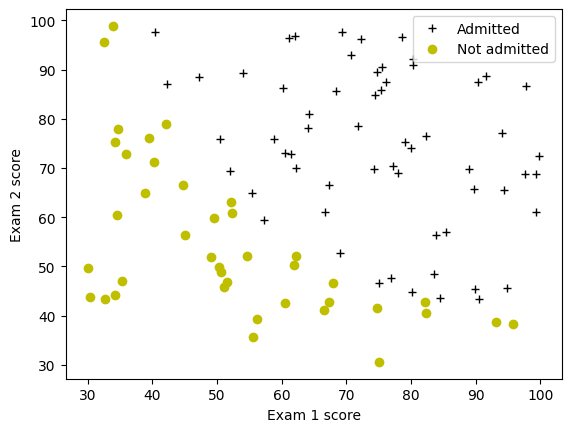

In [5]:
# Plot examples
plot_data(
    X_train,
    y_train.reshape(
        -1,
    ),
    pos_label="Admitted",
    neg_label="Not admitted",
)

# Set the y-axis label
plt.ylabel("Exam 2 score")
# Set the x-axis label
plt.xlabel("Exam 1 score")
plt.legend(loc="upper right")
plt.show()

### Train logistic regresion model


Before we train our model, we normalize the data using z-score. This is not done in the practice lab.


In [6]:
# Normalize input for better convergence
X_norm, X_mean, X_std = z_score_normalization(X_train)

In [7]:
epochs = 10000  # iterations
learning_rate = 0.001  # alpha

model = Linear(X_norm.shape[1], 1)


cost = torch.nn.BCELoss()  # <------ Use cross entropy loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_norm).sigmoid()  # <--- Apply sigmoid to the linear output

    loss = cost(outputs, y_train)

    loss.backward()

    optimizer.step()

    print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.7319084967898902
epoch 1, loss 0.7317410577931645
epoch 2, loss 0.7315736919374228
epoch 3, loss 0.731406399197592
epoch 4, loss 0.7312391795485925
epoch 5, loss 0.7310720329653384
epoch 6, loss 0.7309049594227366
epoch 7, loss 0.7307379588956883
epoch 8, loss 0.7305710313590876
epoch 9, loss 0.7304041767878229
epoch 10, loss 0.7302373951567753
epoch 11, loss 0.7300706864408205
epoch 12, loss 0.7299040506148273
epoch 13, loss 0.729737487653658
epoch 14, loss 0.7295709975321687
epoch 15, loss 0.7294045802252094
epoch 16, loss 0.7292382357076241
epoch 17, loss 0.7290719639542496
epoch 18, loss 0.7289057649399174
epoch 19, loss 0.7287396386394525
epoch 20, loss 0.7285735850276734
epoch 21, loss 0.7284076040793928
epoch 22, loss 0.728241695769417
epoch 23, loss 0.7280758600725465
epoch 24, loss 0.7279100969635754
epoch 25, loss 0.7277444064172923
epoch 26, loss 0.7275787884084787
epoch 27, loss 0.7274132429119108
epoch 28, loss 0.7272477699023586
epoch 29, loss 0.7270823693

### Plot decision boundary


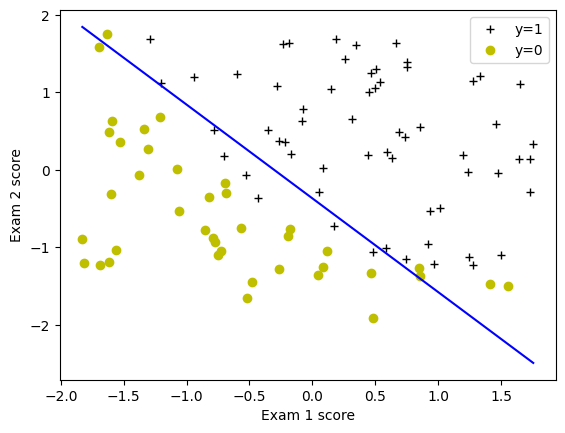

In [8]:
w = model.weight.detach().reshape(model.weight.shape[1])
b = model.bias.detach()[0].item()

plot_decision_boundary(
    w,
    b,
    X_norm,
    y_train.reshape(
        -1,
    ),
)
# Set the y-axis label
plt.ylabel("Exam 2 score")
# Set the x-axis label
plt.xlabel("Exam 1 score")
plt.legend(loc="upper right")
plt.show()

### Evaluation


In [9]:
p = (model(X_norm) > 0.5).int()

print("Train Accuracy: %f" % ((p == y_train).float().mean() * 100))

Train Accuracy: 84.000000


## Part 2 : Regularized Logistic Regression


In [10]:
X_train, y_train = load_data("data/ex2data2.txt")

In [11]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:", type(X_train), end="\n\n")

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:", type(y_train), end="\n\n")

print("The shape of X_train is: " + str(X_train.shape))
print("The shape of y_train is: " + str(y_train.shape))
print("We have m = %d training examples" % (len(y_train)))

X_train: tensor([[ 0.0513,  0.6996],
        [-0.0927,  0.6849],
        [-0.2137,  0.6923],
        [-0.3750,  0.5022],
        [-0.5132,  0.4656]])
Type of X_train: <class 'torch.Tensor'>

y_train: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Type of y_train: <class 'torch.Tensor'>

The shape of X_train is: torch.Size([118, 2])
The shape of y_train is: torch.Size([118, 1])
We have m = 118 training examples


### Visualize data


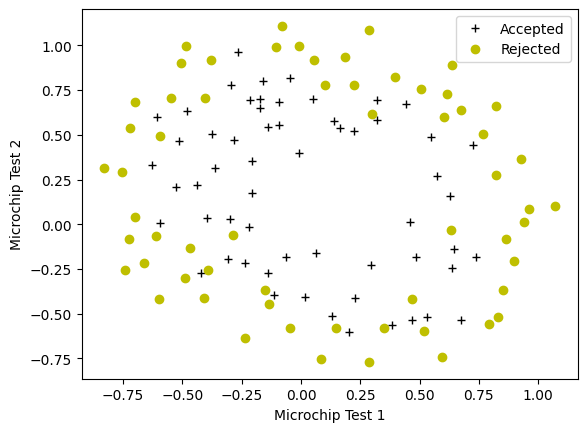

In [12]:
# Plot examples
plot_data(
    X_train,
    y_train.reshape(
        -1,
    ),
    pos_label="Accepted",
    neg_label="Rejected",
)

# Set the y-axis label
plt.ylabel("Microchip Test 2")
# Set the x-axis label
plt.xlabel("Microchip Test 1")
plt.legend(loc="upper right")
plt.show()

### Feature mapping (Polynomial)


In [13]:
print("Original shape of data:", X_train.shape)

# From https://stackoverflow.com/questions/73864186/polynomial-features-using-numpy-or-torch
# equivalent to map_feature in the practice lab
mapped_X = polynomial(X_train, 6)

print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: torch.Size([118, 2])
Shape after feature mapping: torch.Size([118, 27])


In [14]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: tensor([0.0513, 0.6996])
mapped X_train[0]: tensor([5.1267e-02, 6.9956e-01, 2.6283e-03, 3.5864e-02, 4.8938e-01, 1.3475e-04,
        1.8387e-03, 2.5089e-02, 3.4235e-01, 6.9080e-06, 9.4262e-05, 1.2863e-03,
        1.7551e-02, 2.3950e-01, 3.5415e-07, 4.8326e-06, 6.5942e-05, 8.9981e-04,
        1.2278e-02, 1.6754e-01, 1.8156e-08, 2.4775e-07, 3.3807e-06, 4.6131e-05,
        6.2947e-04, 8.5894e-03, 1.1721e-01])


### Train model with polynomial features


In [15]:
# Normalize input
X_norm, X_mean, X_std = z_score_normalization(mapped_X)

In [16]:
epochs = 10000  # iterations
learning_rate = 0.001  # alpha
regularization = 0.01  # lambda *************

model = Linear(X_norm.shape[1], 1, dtype=X_train.dtype)


cost = torch.nn.BCELoss()  # <------ Use cross entropy loss function
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=regularization
)  # <----- Setting regularization

for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_norm).sigmoid()  # <--- Apply sigmoid to the linear output

    loss = cost(outputs, y_train)

    loss.backward()

    optimizer.step()

    print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.8705790965602321
epoch 1, loss 0.8699162739387818
epoch 2, loss 0.8692545181211648
epoch 3, loss 0.8685938294005721
epoch 4, loss 0.8679342080688809
epoch 5, loss 0.8672756544166228
epoch 6, loss 0.8666181687329496
epoch 7, loss 0.8659617513056003
epoch 8, loss 0.8653064024208683
epoch 9, loss 0.8646521223635667
epoch 10, loss 0.8639989114169948
epoch 11, loss 0.8633467698629037
epoch 12, loss 0.8626956979814613
epoch 13, loss 0.8620456960512187
epoch 14, loss 0.8613967643490735
epoch 15, loss 0.8607489031502366
epoch 16, loss 0.8601021127281948
epoch 17, loss 0.8594563933546764
epoch 18, loss 0.8588117452996147
epoch 19, loss 0.8581681688311119
epoch 20, loss 0.8575256642154017
epoch 21, loss 0.8568842317168147
epoch 22, loss 0.85624387159774
epoch 23, loss 0.8556045841185876
epoch 24, loss 0.854966369537752
epoch 25, loss 0.8543292281115743
epoch 26, loss 0.8536931600943036
epoch 27, loss 0.85305816573806
epoch 28, loss 0.8524242452927955
epoch 29, loss 0.851791399006

epoch 723, loss 0.6300956009397495
epoch 724, loss 0.6299726230766614
epoch 725, loss 0.6298498866991838
epoch 726, loss 0.6297273909867644
epoch 727, loss 0.6296051351221291
epoch 728, loss 0.6294831182912697
epoch 729, loss 0.6293613396834319
epoch 730, loss 0.6292397984911028
epoch 731, loss 0.6291184939099982
epoch 732, loss 0.6289974251390514
epoch 733, loss 0.6288765913803998
epoch 734, loss 0.6287559918393735
epoch 735, loss 0.6286356257244831
epoch 736, loss 0.628515492247407
epoch 737, loss 0.6283955906229803
epoch 738, loss 0.6282759200691813
epoch 739, loss 0.6281564798071202
epoch 740, loss 0.6280372690610274
epoch 741, loss 0.6279182870582408
epoch 742, loss 0.6277995330291939
epoch 743, loss 0.6276810062074037
epoch 744, loss 0.6275627058294592
epoch 745, loss 0.627444631135009
epoch 746, loss 0.62732678136675
epoch 747, loss 0.6272091557704139
epoch 748, loss 0.6270917535947576
epoch 749, loss 0.6269745740915493
epoch 750, loss 0.626857616515558
epoch 751, loss 0.6267408

### Plot decision boundary


torch.Size([50, 50])


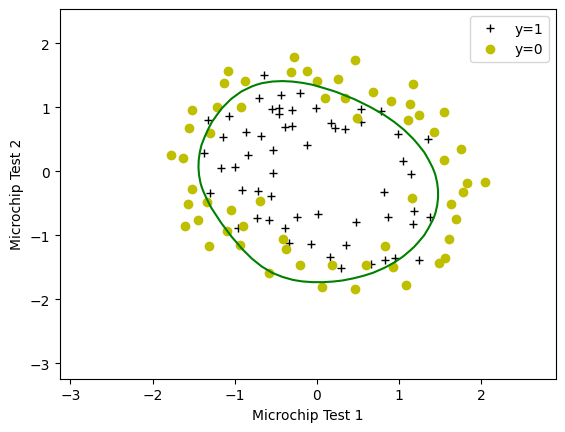

In [17]:
w = model.weight.detach().reshape(model.weight.shape[1])
b = model.bias.detach()[0].item()

plot_decision_boundary(
    w,
    b,
    X_norm,
    y_train.reshape(
        -1,
    ),
    X_mean,
    X_std,
    model,
)
# Set the y-axis label
plt.ylabel("Microchip Test 2")
# Set the x-axis label
plt.xlabel("Microchip Test 1")
plt.legend(loc="upper right")
plt.show()

### Evaluation


In [18]:
p = (model(X_norm).detach().sigmoid().float() > 0.5).float()

print("Train Accuracy: %f" % ((p == y_train).float().mean() * 100))

Train Accuracy: 82.203384
